In [1]:
import json
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# expects pandas == 2.0.1 and sns == 0.12.2
# installing requirements file sets pandas == 2.0.3

In [2]:
SRC_DIRECTORY = r"C:\Users\vsornapudi\Documents\github\setup_training_environment\machine-reading-comprehension\src"

TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'train-v2.0.json')
DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'dev-v2.0.json')

PROCESSED_TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_train_2017", 'squad_like_json.json')
PROCESSED_DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_dev_2017", 'squad_like_json.json')

In [3]:
def squad_load(data_path):
    """
    Loads train/dev/test dataset json file.

    :param data_path: path to data file to read json from
    :return: list of documents in the dataset
    """
    with open(data_path, 'r') as f:
        docs = json.load(f)
    return docs

In [4]:
def print_1d_stats(vector_1d):
    print(f"Maximum of {np.max(vector_1d)} at index: {np.argmax(vector_1d)}")
    print(f"Mininmun of {np.min(vector_1d)} at index: {np.argmin(vector_1d)}")
    print(f"Mean is {np.mean(vector_1d)}")
    print(f"Variance is {np.var(vector_1d)}")
    print(f"Median is {np.median(vector_1d)}")


def generate_1d_graphs(vector, title):
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    sns.boxplot(data=vector, ax=axes[0])
    sns.histplot(vector, kde=True, bins=25, ax=axes[1])
    fig.suptitle(title)
    fig.tight_layout(pad=3.0)
    plt.show()

def flatten(l):
    return [item for sublist in l for item in sublist]

def first_2_words_piechart(strings):

    word1 = flatten([string[0:1] for string in strings])
    word2 = flatten([string[1:2] for string in strings])

    len_word1 = len(word1)
    len_word2 = len(word2)

    word1 = Counter(word1)
    word2 = Counter(word2)

    word1_values = [int(100* value / len_word1) for value in word1.values()]
    word2_values = [int(100* value / len_word2) for value in word2.values()]

    cleaned_word1_values = [value for value in word1_values if value > 1]
    cleaned_word2_values = [value for value in word2_values if value > 1]

    others_word1_values = sum([value for value in word1_values if value <= 1])
    others_word2_values = sum([value for value in word2_values if value <= 1])
    cleaned_word1_values.append(others_word1_values)
    cleaned_word2_values.append(others_word2_values)

    cleaned_word1_keys = [key for i, key in enumerate(word1.keys()) if word1_values[i] > 1]
    cleaned_word2_keys = [key for i, key in enumerate(word2.keys()) if word2_values[i] > 1]
    cleaned_word1_keys.append("'others'")
    cleaned_word2_keys.append("'others'")

    fig, ax = plt.subplots(figsize=(8,10))
    size = 0.4

    ax.pie(cleaned_word1_values, 
        radius=1,
        labels=cleaned_word1_keys,
        labeldistance = 0.7,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.pie(cleaned_word2_values, 
        radius=1-size, 
        labels = cleaned_word2_keys,
        labeldistance = 0.5,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.set(aspect="equal", title='First 2 words of questions')
    plt.show()

In [9]:
def stats_and_graphs(docs):

    print(f"Number of documents: {len(docs)}\n")
    n_qas_per_para = []

    qa_list = []
    for doc in docs:
        for para in doc['paragraphs']:
            for qas in para['qas']:
                qa_list.append(qas)
                n_qas_per_para.append(len(qas))

    questions = [qas['question'].strip() for qas in qa_list] #### strip is must####
    answers = [[answer['text'].strip() for answer in qas['answers']] for qas in qa_list if not qas['is_impossible']]

    # questions stats

    print("QUESTIONS -------->\n")
    print(f"Number of questions: {len(questions)}")
    print(f"Number of unique questions: {len(set(questions))}\n")

    questions_words = []
    for question in questions:
        questions_words.extend(question.split(" "))
    print(f"Number of distinct words in questions: {len(set(questions_words))}")

    questions_lengths = [len(question.split(" ")) for question in questions]
    print("\n|| Question length stats:")
    print_1d_stats(questions_lengths)
    generate_1d_graphs(questions_lengths, 'Question lengths')

    n_q_per_doc = {}
    for doc_id, doc in enumerate(docs):
        for i, para in enumerate(doc['paragraphs']):
            if i==0:
                n_q_per_doc[doc_id] = len(para['qas'])
            else:
                n_q_per_doc[doc_id] += len(para['qas'])
    n_q_per_doc = list(n_q_per_doc.values())
    print("\n|| # Questions per document stats:")
    print_1d_stats(n_q_per_doc)
    generate_1d_graphs(n_q_per_doc, '# Questions per document')

    n_answers = 0
    n_a_per_doc = {}
    for doc_id, doc in enumerate(docs):
        i=0
        for para in doc['paragraphs']:
            for qas in para['qas']:
                if not qas['is_impossible']:
                    if i==0:
                        n_a_per_doc[doc_id] = 1
                        n_answers += len(qas['answers'])
                        i += 1
                    else:
                        n_a_per_doc[doc_id] += 1
                        n_answers += len(qas['answers'])
    n_a_per_doc = list(n_a_per_doc.values())
    print(f"Number of answerable questions: {sum(n_a_per_doc)}")
    print(f"Number of answers: {n_answers}") 

    print("\n|| # Answerable questions per document stats:")
    print_1d_stats(n_a_per_doc)
    generate_1d_graphs(n_a_per_doc, '# Answerable questions per document')

    first_2q_words = []
    for question in questions:
        first_2q_words.append(question.split(" ")[:2])
    first_2_words_piechart(first_2q_words)

    print("\n|| # Questions per paragraph stats:")
    print_1d_stats(n_qas_per_para)
    generate_1d_graphs(n_qas_per_para, '# Questions per paragraph')
   
    # answer stats

    print("\nANSWERS -------->\n")
    answer_lengths = [np.mean([len(ans.split(" ")) for ans in answer]) for answer in answers]

    # n distinct words in answers
    answers_words = []
    for answer in answers:
        for ans in answer:
            answers_words.extend(ans.split(" "))
    print(f"Number of distinct words in answers: {len(set(answers_words))}")

    print("\n|| Answer length stats:")
    print_1d_stats(answer_lengths)
    generate_1d_graphs(answer_lengths, 'Answer lengths') 

    n_answers_per_question = [len(qas['answers']) for qas in qa_list]
    n_impossible_questions = sum([1 for n_answers in n_answers_per_question if n_answers==0])
    n_single_answers = sum([1 for n_answers in n_answers_per_question if n_answers==1])
    n_multi_answers = sum([1 for n_answers in n_answers_per_question if n_answers>1])

    print(f"Number of unanswerable questions: {n_impossible_questions}")
    print(f"Number of questions having one answer: {n_single_answers}")
    print(f"Number of questions having more than one answer: {n_multi_answers}")

    print("\n|| Answers per question stats:")
    print_1d_stats(n_answers_per_question)
    generate_1d_graphs(n_answers_per_question, '# Answers per question') 

    # paragraph stats
    print("\nPARAGRAPHS -------->\n")

    paras = {}
    for doc_id, doc in enumerate(docs):
        paras[doc_id] = [para['context'] for para in doc['paragraphs']]
    para_list = flatten(paras.values())

    print(f"Number of paragraphs in dataset: {len(flatten(paras.values()))}")

    para_lengths = [len(para.split(" ")) for para in para_list]
    print("\n|| Paragraph length stats:")
    print_1d_stats(para_lengths)
    generate_1d_graphs(para_lengths, 'Paragraph lengths')

    para_counts = [len(para) for para in paras.values()]
    print("\n|| # Paragraphs per doc stats:")
    print_1d_stats(para_counts)
    generate_1d_graphs(para_counts, '# Paragraphs per doc')


# Original Dataset

In [10]:
org_docs = squad_load(TRAINSET_PATH)['data'] + squad_load(DEVSET_PATH)['data']

Number of documents: 477

QUESTIONS -------->

Number of questions: 142192
Number of unique questions: 142040

Number of distinct words in questions: 80457

|| Question length stats:
Maximum of 40 at index: 45706
Mininmun of 1 at index: 50678
Mean is 9.911134241026218
Variance is 11.766084535484467
Median is 9.0


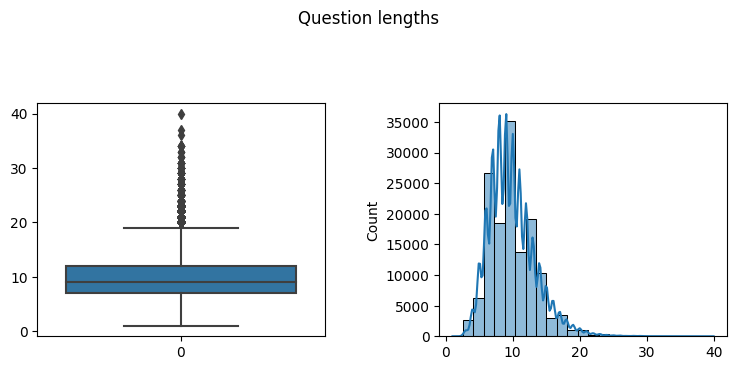


|| # Questions per document stats:
Maximum of 883 at index: 171
Mininmun of 36 at index: 105
Mean is 298.0964360587002
Variance is 11636.166800715513
Median is 282.0


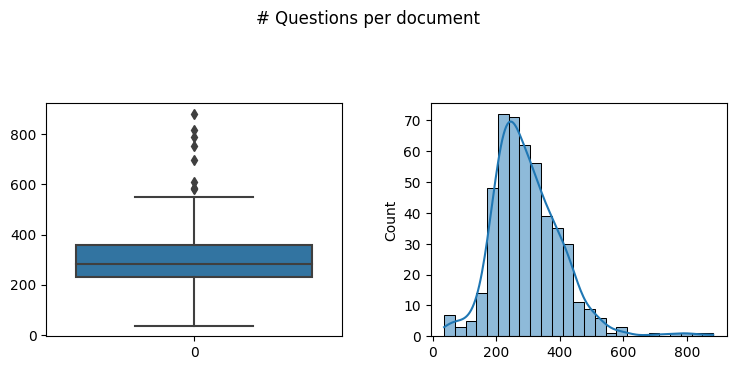

Number of answerable questions: 92749
Number of answers: 107123

|| # Answerable questions per document stats:
Maximum of 817 at index: 7
Mininmun of 36 at index: 105
Mean is 195.26105263157893
Variance is 12732.689746260388
Median is 169.0


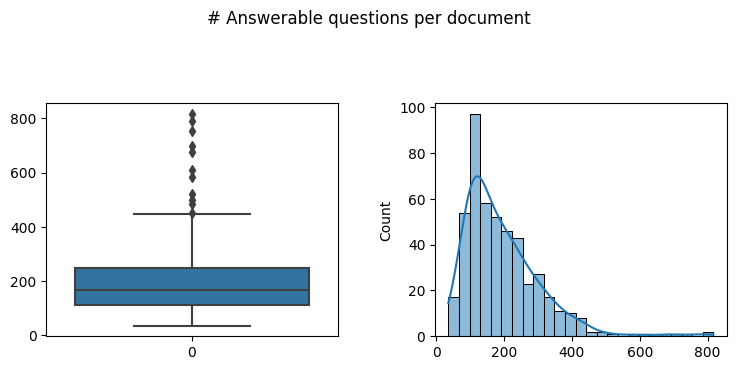

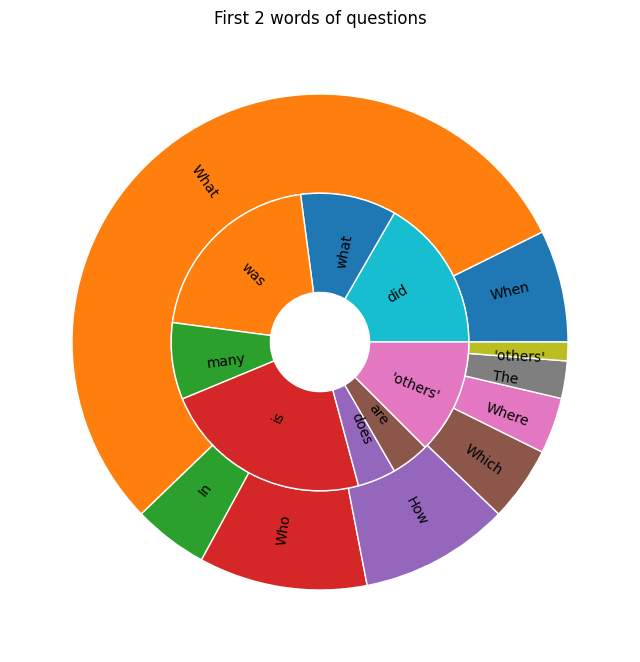


|| # Questions per paragraph stats:
Maximum of 5 at index: 2075
Mininmun of 4 at index: 0
Mean is 4.347719984246653
Variance is 0.22681079680216024
Median is 4.0


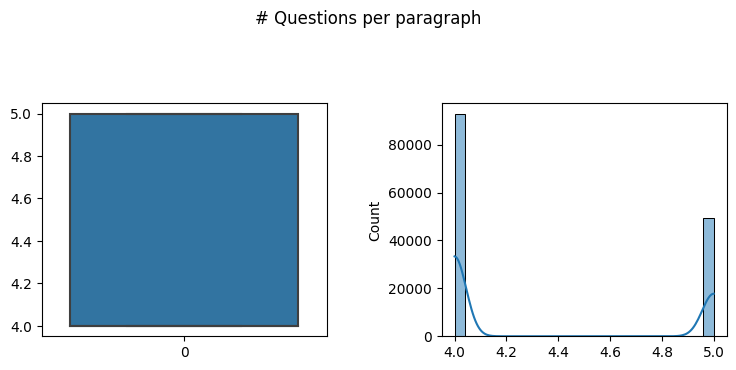


ANSWERS -------->

Number of distinct words in answers: 58454

|| Answer length stats:
Maximum of 43.0 at index: 2853
Mininmun of 1.0 at index: 2
Mean is 3.1550604319184035
Variance is 11.202759414568725
Median is 2.0


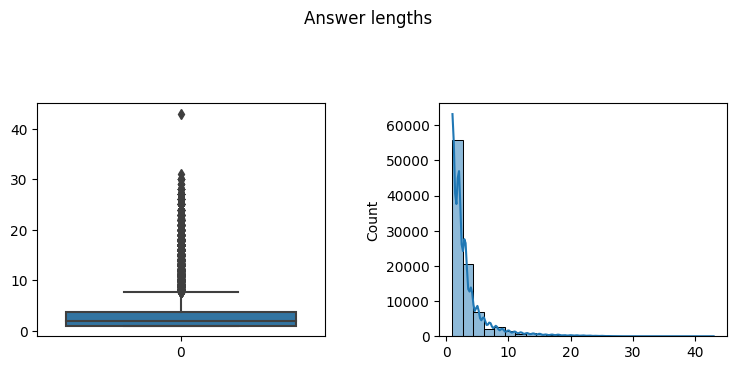

Number of unanswerable questions: 49443
Number of questions having one answer: 86822
Number of questions having more than one answer: 5927

|| Answers per question stats:
Maximum of 6 at index: 135986
Mininmun of 0 at index: 2075
Mean is 0.7533686845954766
Variance is 0.5580756048165774
Median is 1.0


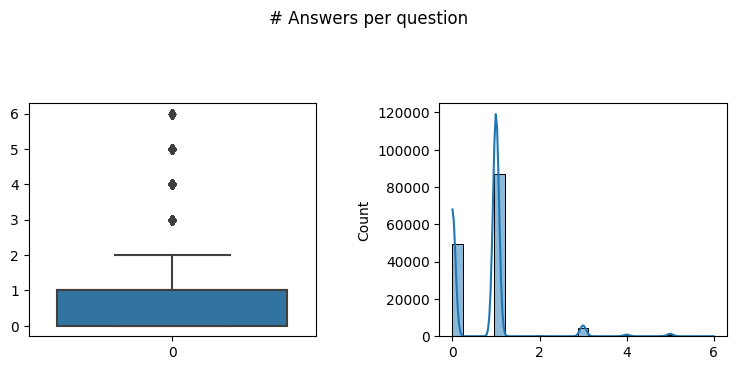


PARAGRAPHS -------->

Number of paragraphs in dataset: 20239

|| Paragraph length stats:
Maximum of 653 at index: 12251
Mininmun of 20 at index: 2199
Mean is 117.17930727802757
Variance is 2522.4925289731727
Median is 108.0


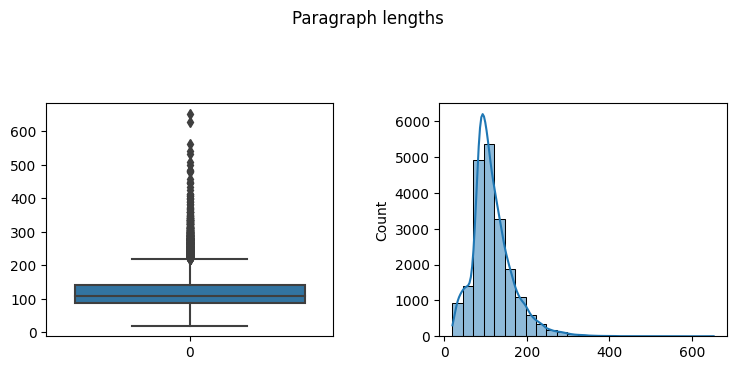


|| # Paragraphs per doc stats:
Maximum of 149 at index: 11
Mininmun of 10 at index: 105
Mean is 42.42976939203354
Variance is 437.8844806596082
Median is 37.0


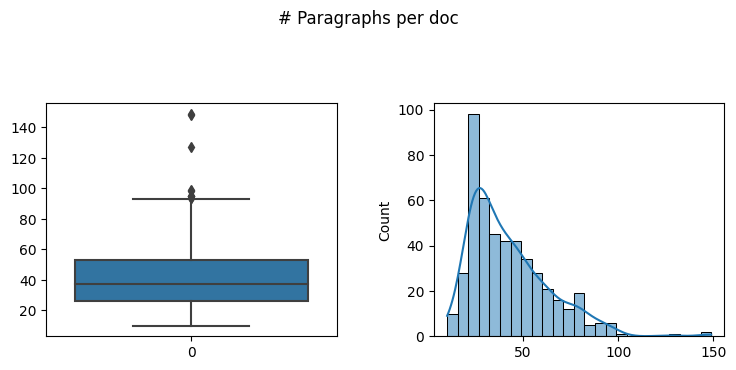

In [11]:
stats_and_graphs(org_docs)

# Processed Dataset

Number of documents: 457

QUESTIONS -------->

Number of questions: 124827
Number of unique questions: 124692

Number of distinct words in questions: 74689

|| Question length stats:
Maximum of 40 at index: 40231
Mininmun of 1 at index: 44398
Mean is 9.883366579345815
Variance is 11.646414109356915
Median is 9.0


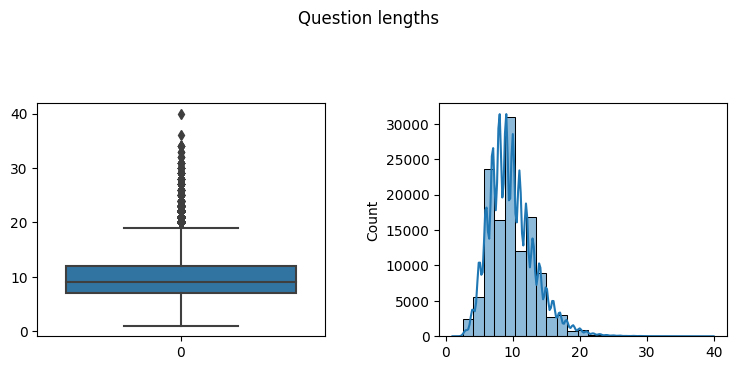


|| # Questions per document stats:
Maximum of 867 at index: 167
Mininmun of 36 at index: 105
Mean is 273.14442013129104
Variance is 10351.33581678629
Median is 256.0


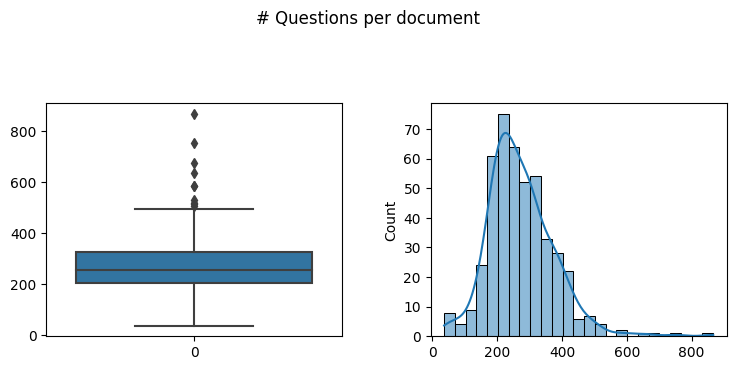

Number of answerable questions: 77510
Number of answers: 81073

|| # Answerable questions per document stats:
Maximum of 752 at index: 12
Mininmun of 21 at index: 38
Mean is 171.48230088495575
Variance is 10460.869155767874
Median is 145.0


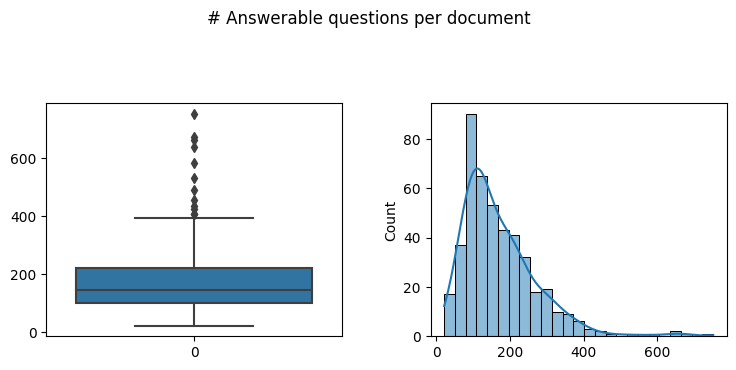

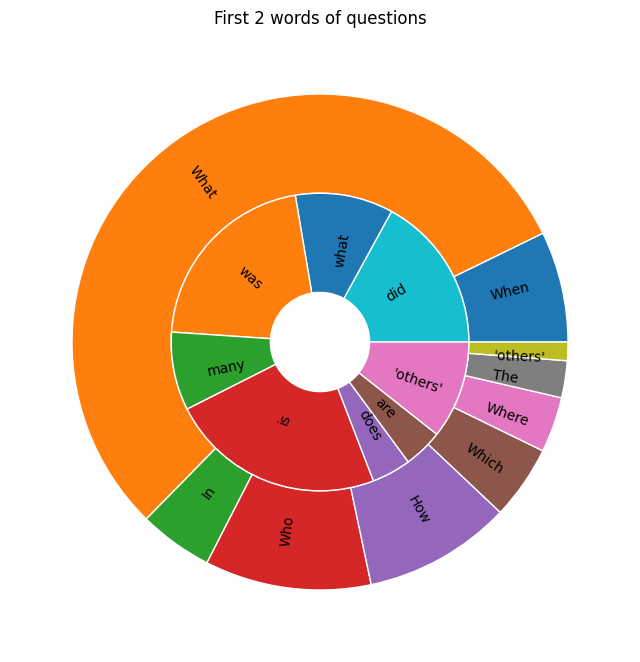


|| # Questions per paragraph stats:
Maximum of 124827 at index: 124826
Mininmun of 1 at index: 0
Mean is 62414.0
Variance is 1298481660.6666667
Median is 62414.0


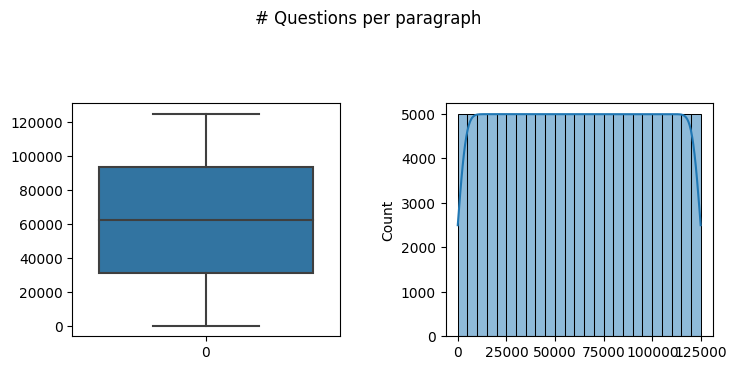


ANSWERS -------->

Number of distinct words in answers: 51010

|| Answer length stats:
Maximum of 43.0 at index: 2352
Mininmun of 1.0 at index: 2
Mean is 3.118057239926031
Variance is 10.833500557024053
Median is 2.0


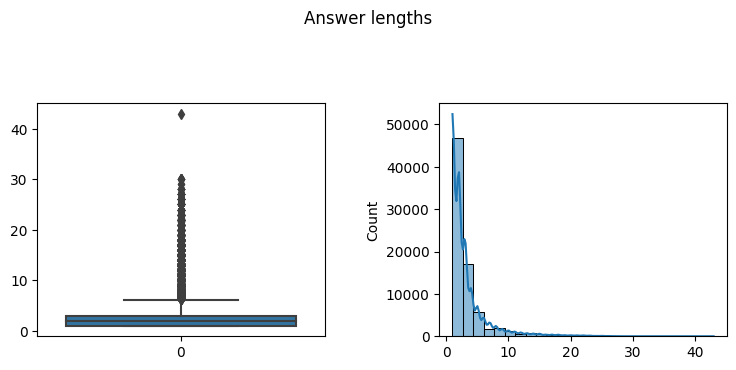

Number of unanswerable questions: 47317
Number of questions having one answer: 74944
Number of questions having more than one answer: 2566

|| Answers per question stats:
Maximum of 5 at index: 119025
Mininmun of 0 at index: 1784
Mean is 0.6494828843118876
Variance is 0.3040966627426946
Median is 1.0


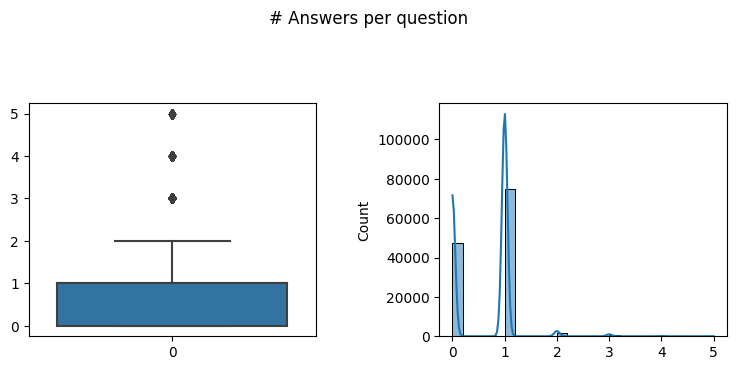


PARAGRAPHS -------->

Number of paragraphs in dataset: 18850

|| Paragraph length stats:
Maximum of 562 at index: 12600
Mininmun of 8 at index: 14479
Mean is 116.73761273209549
Variance is 2555.343036210766
Median is 108.0


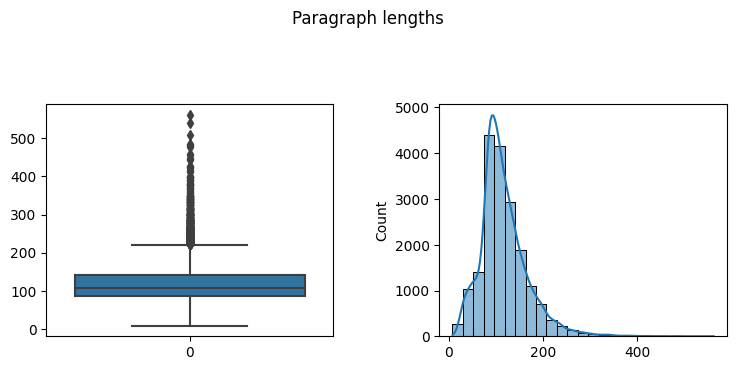


|| # Paragraphs per doc stats:
Maximum of 139 at index: 7
Mininmun of 1 at index: 166
Mean is 41.2472647702407
Variance is 391.5034115557173
Median is 36.0


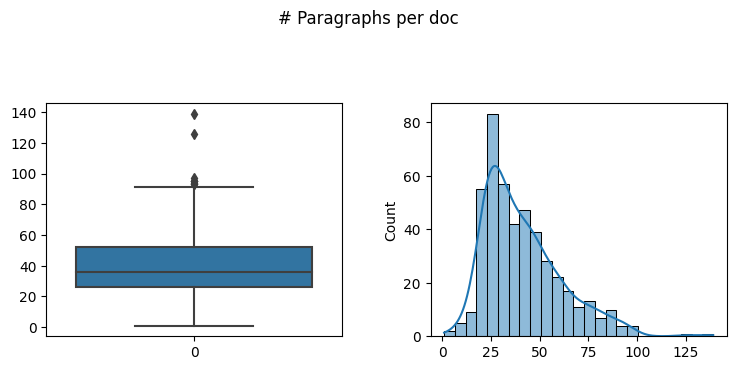

In [8]:
PROCESSED_DATASET_PATH = r"C:\Users\vsornapudi\Documents\github\setup_training_environment\machine-reading-comprehension\src\outputs\29_06_data\squad_like_json.json"
stats_and_graphs(squad_load(PROCESSED_DATASET_PATH))